In [1]:
saveNames='siameseUnet-nomask-affine'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1,2,3" #change to the number of gpu's you want
# os.environ["CUDA_VISIBLE_DEVICES"]= "4,5,6,7" #change to the number of gpu's you want

In [3]:
import keras

Using TensorFlow backend.


In [4]:
import pickle

In [5]:
from keras import backend as K
K.set_image_dim_ordering('th')

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Flatten, Activation, Subtract, Multiply
from keras.layers import Conv3D, MaxPooling3D, Dropout, Concatenate, Dense, AveragePooling3D, AveragePooling2D, BatchNormalization, UpSampling3D, GlobalAveragePooling2D, GlobalAveragePooling3D
from keras.layers import Lambda, Reshape
from keras import regularizers
import nibabel as nib
from pathlib import Path #req python 3.4
import scipy.misc
import os.path
from tqdm import tqdm
from scipy.ndimage import affine_transform
import numpy
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import sys
import math

In [7]:
def slice(index):
    def func(x):
        return x[:,index,...]
    return Lambda(func)

#takes in 2 ?,12,64^3 images, performs sumx/sumy -> ?,12 output
def maskops4d(x):#orig tensor
    def func(y):#mask
#         print(y)
        xSum = K.sum(K.sum(K.sum(x,axis=2),axis=2), axis=2) #never do the batch dim
        ySum = K.sum(K.sum(K.sum(y,axis=2),axis=2), axis=2)
#         print(xSum)
#         print(ySum)
#         oneover=1/ySum
#         print(oneover)
        result = xSum/ySum  # this does an element wise 1/ operation, double checked. 
#         print(result)
#         print(result.shape)
        return result
    return Lambda(func)


#https://stackoverflow.com/questions/44810826/how-to-share-convolution-kernels-between-layers-in-keras

i1=Input(shape=(1,64,64,64)) #tgt
i2=Input(shape=(1,64,64,64)) #src
# i11=AveragePooling3D()(i1)
# i22=AveragePooling3D()(i2)



s1= Conv3D(16, 3 ,padding='same')#second conv 
s2= Conv3D(16, 3 ,padding='same')#second conv 
s3= Conv3D(16, 3 ,padding='same')#second conv 
s4= Conv3D(16, 3 ,padding='same')#second conv 
#these 2 are layer 1
d1= Conv3D(16, 3,padding='same')#first conv 
d2= Conv3D(32, 3 ,padding='same')#second conv 
d3= Conv3D(32, 3, padding='same')
d4= Conv3D(32, 3, padding='same')
d5= Conv3D(32, 3, padding='same')

u1= Conv3D(32, 3, padding='same')
u2= Conv3D(32, 3, padding='same')
u3= Conv3D(32, 3, padding='same')
u4= Conv3D(32, 3,padding='same')
u5= Conv3D(32, 3,padding='same')
u6= Conv3D(16, 3,padding='same')
u7= Conv3D(12, 1,padding='same', use_bias=False)

getMask = Conv3D(32,3,padding='same')
getMask2=Conv3D(32,3,padding='same')
getMask3=Conv3D(32,3,padding='same')
mask = Conv3D(12, 3,padding='same')#, kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None))
# pc2_3= Conv3D(32, 3,padding='same')
# pc2_4= Conv3D(32, 3,padding='same')
# pc3= Conv3D(32, 3,padding='same')
# pc4= Conv3D(32, 3,padding='same')
# pc1by1=Conv3D(128,1,padding='same')
# pc1by1num2=Conv3D(3,1,padding='same') # this could be used instead of a dense layer
# pc3= Conv3D(64, 3,padding='same')

# out1=AveragePooling3D()(i1)
# out1=AveragePooling3D()(out1)
# out1=AveragePooling3D()(out1)
slay1=s1(i1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)
slay1=s2(slay1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)
slay1=s3(slay1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)
slay1=s4(slay1)
slay1=BatchNormalization()(slay1) #not enough memory to batchnorm
slay1=Activation('relu')(slay1)

slay2=s1(i2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)
slay2=s2(slay2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)
slay2=s3(slay2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)
slay2=s4(slay2)
slay2=BatchNormalization()(slay2) #not enough memory to batchnorm
slay2=Activation('relu')(slay2)

con=Concatenate(axis=1)([slay1,slay2]) 
d256=d1(con)
d256=BatchNormalization()(d256) #not enough memory to batchnorm
d256=Activation('relu')(d256)
d128=MaxPooling3D(pool_size=(2,2,2))(d256)
d128=d2(d128)
d128=BatchNormalization()(d128)
d128=Activation('relu')(d128)
d64=MaxPooling3D(pool_size=(2,2,2))(d128)
d64=d3(d64)
d64=BatchNormalization()(d64)
d64=Activation('relu')(d64)
d32=MaxPooling3D(pool_size=(2,2,2))(d64)
d32=d4(d32)
d32=BatchNormalization()(d32)
d32=Activation('relu')(d32)
d16=MaxPooling3D(pool_size=(2,2,2))(d32)
d16=d5(d16)
d16=BatchNormalization()(d16)
# d16=Activation('relu')(d16)
#smallest layer ends here
u32=UpSampling3D()(d16)
u32=Concatenate(axis=1)([u32,d32]) 
u32=u1(u32)
u32=BatchNormalization()(u32)
# u32=Activation('relu')(u32)
u64=UpSampling3D()(u32)
u64=Concatenate(axis=1)([u64,d64]) 
u64=u2(u64)
u64=BatchNormalization()(u64)
# u64=Activation('relu')(u64)
u128=UpSampling3D()(u64)
u128=Concatenate(axis=1)([u128,d128]) 
u128=u3(u128)
u128=BatchNormalization()(u128)
# u128=Activation('relu')(u128)
u256=UpSampling3D()(u128)
u256=Concatenate(axis=1)([u256,d256]) 
u256=u4(u256)
u256=BatchNormalization()(u256)
# u256=Activation('relu')(u256)
maskfeed=u5(u256)
fout=u7(maskfeed)
fout=GlobalAveragePooling3D()(fout)
# premask = getMask(maskfeed)
# premask=getMask2(premask)
# premask=getMask3(premask)
# masked = mask(premask)
# masked=Activation('sigmoid')(masked)

# mult=Multiply(name="mult")([u256,K.variable(numpy.zeros((4,3,64,64,64)))]) #test to see if the mult is actually doing anything
# mult=Multiply(name="mult")([fout,masked]) 

# out3=maskops4d(mult)(masked)

model=Model(inputs=[i1, i2],outputs=fout)
# opt=keras.optimizers.Adam(lr=0.0001)
# opt=keras.optimizers.Adam(lr=0.0005)
opt=keras.optimizers.Adam(lr=0.001) #performs ok on the 3 layer->concat->2 layers of (conv->bn->relu)->dense, batch size 4
# opt=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999) #adam defaults to b1=0.9, b2=0.999
# opt=keras.optimizers.Adam(lr=0.01) # 10x default learn rate
# opt=keras.optimizers.Adadelta() # using the default hyperparams, this thing even after 1k brains of training, still predicts random warps
model.compile(optimizer=opt,loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 64, 64, 64 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 64, 64, 64 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 64, 64, 6 448         input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 64, 64, 6 256         conv3d_1[0][0]                   
__________

In [8]:
#validation test dataset:
transforms = numpy.genfromtxt('rand_affine_transforms_small_5std_0mu_01std_0mu.csv', delimiter=',')
i=0
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
vSize=4 #4 pairs of images
inBatch=0
testThestas=transforms[-(vSize):]
nameString='saved_small_brains/MCIC-small-test-std5-mu0-64-'
while inBatch<vSize:
    fname1 = str(testDirectories[i])+'/mri/norm.mgz'
    if os.path.isfile(fname1):
        scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
        if numpy.count_nonzero(scan)!=0: # make sure skull strip is not blank
            inBatch+=1
            #have i already transformed this before?
            if os.path.isfile(nameString+str(inBatch)+'.npy'):
                aScan=numpy.load(nameString+str(inBatch)+'.npy')
            else:
                warp=[transforms[i,0:3],transforms[i,4:7],testThestas[i,8:11]]
                aScan=affine_transform(scan,warp, offset=testThestas[i,3:15:4])
                aScan=numpy.expand_dims(numpy.expand_dims(aScan, axis=0), axis=0)
                #we're gonna save the warp numpy 3d array to save some time later
                numpy.save(nameString+str(inBatch),aScan)
            if inBatch==1:
                v2=aScan
            else:
                v2=numpy.append(v2,aScan,axis=0)
            scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
            if inBatch==1:
                v1=scan
            else:
                v1=numpy.append(v1,scan, axis=0)
    i+=1


In [2]:
testThestas=testThestas[:len(v1)]

NameError: name 'testThestas' is not defined

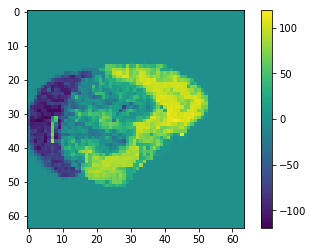

In [33]:
# masking experiments
plt.imshow(numpy.squeeze(v1[1,0,35,...].astype('float')-v2[1,0,35,...].astype('float')))
# plt.show()
plt.colorbar()

In [20]:
# generate random affine transforms
import csv 
num=1000000
mu, sigma = 1, 0.1 # diagonals of the affine transform
d = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ##INCREASED
mu, sigma = 5, 5 # offsets
o = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ## STAYS THE SAME
mu, sigma = 0, 0.1 # others
others = numpy.random.normal(mu, sigma, 6*num) # 6 columns of 10k ##INCREASED
with open('rand_affine_transforms_small_5std_5mu.csv','w',newline='') as csvfile:
    writer = csv.writer(csvfile,delimiter = ',')
    for row in range(num):
        writer.writerow([d[row],others[row],others[row+num],o[row],others[row+2*num],d[row+num],others[row+3*num],o[row+num],others[row+4*num],others[row+5*num],d[row+2*num],o[row+2*num]])

In [11]:
# generate random affine transforms
import csv 
num=1000000
mu, sigma = 1, 0.1 # diagonals of the affine transform
d = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ##INCREASED
mu, sigma = 0, 5 # offsets
o = numpy.random.normal(mu, sigma, 3*num) # 3 columns of 10k ## STAYS THE SAME
mu, sigma = 0, 0.1 # others
others = numpy.random.normal(mu, sigma, 6*num) # 6 columns of 10k ##INCREASED
with open('rand_affine_transforms_small_5std_0mu_01std_0mu.csv','w',newline='') as csvfile:
    writer = csv.writer(csvfile,delimiter = ',')
    for row in range(num):
        writer.writerow([d[row],others[row],others[row+num],o[row],others[row+2*num],d[row+num],others[row+3*num],o[row+num],others[row+4*num],others[row+5*num],d[row+2*num],o[row+2*num]])

In [14]:
print(transforms[-(vSize):])

[[  9.37389569e-01  -1.75709699e-01   8.83385864e-02  -3.95055275e+00
    1.29479413e-01   1.05393808e+00  -3.36480551e-02   1.63742927e+01
    1.11524606e-01  -6.45687475e-03   1.04328158e+00  -5.81494244e+00]
 [  1.08851980e+00   2.22335605e-01  -1.00443517e-01   4.49666156e+00
   -8.16478262e-02   9.32853387e-01   1.43088440e-01   8.79982011e-01
   -1.52645275e-01  -1.41172803e-02   9.32813383e-01  -1.71116588e+00]
 [  1.06436094e+00  -6.78197030e-02  -1.68315315e-02   1.16141217e+00
   -1.22706182e-01   1.00502267e+00  -3.07875247e-02  -1.53360007e+01
   -3.97982014e-02  -1.10262548e-01   9.30881896e-01  -1.24775639e+00]
 [  9.79133757e-01   3.39257281e-02  -1.88951922e-01   2.87900940e-01
   -2.01851283e-01   9.23343099e-01  -2.65807950e-02  -7.56334490e+00
    5.07645709e-02   2.41915254e-01   9.46736686e-01  -2.54199844e-02]]


In [9]:
print(testThestas)

[[ 8.54919566e-01 -2.48199136e-02 -2.78968273e-02  3.66246474e+00
   1.58316448e-01  1.04500846e+00  9.06456712e-02 -1.13826657e-01
   2.05182331e-02  4.44956322e-02  1.15116581e+00  2.31505726e+00]
 [ 9.38487268e-01  1.60738639e-01  1.57532834e-01 -5.77429660e+00
   7.32035035e-02  1.11758731e+00 -1.03349582e-01  1.95434895e+00
   1.22188888e-01  3.06584994e-02  1.13627652e+00 -8.75689196e+00]
 [ 9.45199869e-01 -2.47873155e-02  7.90150472e-02 -5.80952185e+00
  -8.71537793e-02  1.22415003e+00  2.12432354e-02  1.12469867e+01
   4.94877516e-02  1.24528346e-01  1.02712215e+00  1.62671830e+00]
 [ 1.17035051e+00 -1.05285961e-02  4.13447515e-02  5.49118013e+00
   6.03431890e-02  1.15415181e+00 -4.38094109e-02  3.60580449e+00
   3.82294477e-02  1.48897580e-01  7.38596617e-01 -7.63209792e-02]]


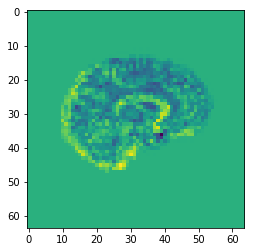

In [14]:
plt.imshow(bScan[0,0,32,...].astype('float')-bAffScan[0,0,32,...].astype('float'))

In [ ]:
#read in the transforms; this should only be 7 mB
warpname='rand_affine_transforms_small_5std_0mu_01std_0mu'
transforms = numpy.genfromtxt(warpname+'.csv', delimiter=',') 
#throw these pieces in a script.py to do real training
# epoch here will be defined as the abide dataset
efilename='efile-'+saveNames+'.txt'
pfilename='pfile-'+saveNames+'.txt'
tfilename='tfile-'+saveNames+'.txt'
predictionsPlot=[]
truthsPlot=[]
errorPlot=[]
testErrors=[]
batchSize=8
tIndex=0
# crop=[25:-25,25:-25,25:-25]
#validation test dataset:
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
for epoch in tqdm(range(100)):
    for dSet in range(3):
        i=0
        totalError=0
        batchNum=0
        numInBatch=0
        if dSet==0: ##brains must be pulled out of saved_brains in this order otherwise the thetas will not be aligned
            p = Path('/nfs01/data/FS_Slim/ABIDE') #brains
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/ABIDE-std5-mu0-64-'
        if dSet==1:
            p = Path('/nfs01/data/FS_Slim/ADHD200') 
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/ADHD200-std5-mu0-64-'
        if dSet==2:
            p = Path('/nfs01/data/FS_Slim/PPMI') 
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/PPMI-std5-mu0-64-'
        while i < len(subdirectories):
            fname1 = str(subdirectories[i])+'/mri/norm.mgz'
            if os.path.isfile(fname1):
                tIndex+=1
                if os.path.isfile(nameString+str(tIndex)+'-normal'+'.npy'):
                    scan=numpy.load(nameString+str(tIndex)+'-normal'+'.npy')
                else:
                    scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
                if numpy.count_nonzero(scan)!=0: # make sure skull strip is not blank
                    if not os.path.isfile(nameString+str(tIndex)+'-normal'+'.npy'):
                        numpy.save(nameString+str(tIndex)+'-normal'+'.npy', scan)
                    numInBatch+=1
                    warp=[transforms[tIndex,0:3],transforms[tIndex,4:7],transforms[tIndex,8:11]]
#                     warp=[[1,0,0],[0,1,0],[0,0,1]]
                    offset = [transforms[tIndex,3],transforms[tIndex,7],transforms[tIndex,11]]
                    match=False
                    if os.path.isfile(nameString+'-'+warpname+'-'+str(tIndex)+'.npy'): #just translation
                        affScan=numpy.load(nameString+'-'+warpname+'-'+str(tIndex)+'.npy')
                    else:
                        affScan=affine_transform(scan,warp,offset=offset)
                        affScan=numpy.expand_dims(numpy.expand_dims(affScan, axis=0), axis=0)
                        #we're gonna save the warp numpy 3d array to save some time later
                        numpy.save(nameString+'-'+warpname+'-'+str(tIndex),affScan)
                    ##now scale the offset down by 50 (how does this work in tensorflow??)
                    scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
#                     transforms[tIndex]*=[1,1,1,1/20,1,1,1,1/20,1,1,1,1/20]
                    if numInBatch==1:
                        bScan=scan
                        bAffScan=affScan
                        bTransforms=transforms[tIndex][numpy.newaxis]
                    else:
                        bScan=numpy.append(bScan,scan, axis=0)
                        bAffScan=numpy.append(bAffScan,affScan, axis=0)
                        bTransforms=numpy.append(bTransforms, transforms[tIndex][numpy.newaxis], axis=0)
                    if numInBatch==batchSize:    
                        batchNum+=1
#                         print(bTransforms)
#                         from IPython.core.debugger import Tracer
#                         Tracer()() #this one triggers the debugger
                        error=model.train_on_batch([bScan,bAffScan],bTransforms*[1,1,1,1/50,1,1,1,1/50,1,1,1,1/50]) # /50 cuz thats the ration btwn std of translation vs affine
                        pred=model.predict([bScan,bAffScan])
                        totalError+=error
                        errorPlot.append(error)
                        predictionsPlot.append(pred)
                        truthsPlot.append(bTransforms)
                        # now do some validation error: a different dataset...
                        tErrors=model.test_on_batch([v1,v2],testThestas)
                        testErrors.append(tErrors)
                        print(('at batch num='+str(batchNum)+' error is: '+str(error)+', and validation error is '+str(tErrors)))
                        if batchNum%10==0:
                            printThetas=model.predict([v1,v2])
                            printThetas*=[1,1,1,50,1,1,1,50,1,1,1,50]
                            print(printThetas)
                            print('dif is ' + str(numpy.sum(numpy.absolute(printThetas-testThestas))))
                        sys.stdout.flush()
                        numInBatch=0
            i+=1
    print("At epoch"+str(epoch)+", scalar error is: "+str(totalError))
    # serialize model to JSON
#     model.save('model-'+saveNames+'.h5')
    model.save_weights("model_weights"+saveNames+".h5")
    with open(efilename, 'wb') as f:
        pickle.dump(errorPlot, f)
    with open(pfilename, 'wb') as f:
        pickle.dump(predictionsPlot, f)
    with open(tfilename, 'wb') as f:
        pickle.dump(truthsPlot, f)
#         model_json = model.to_json()
#         with open("adrian_copy_mean5std5.json", "w") as json_file:
#             json_file.write(model_json)
    # serialize weights to HDF5
#         model.save_weights("adrian_copy_mean5std5_weights.h5")
    print("Saved model to disk")


  0%|          | 0/100 [00:00<?, ?it/s]

at batch num=1 error is: 0.2503448, and validation error is 9.0836525
at batch num=2 error is: 0.71224606, and validation error is 13.48028


at batch num=3 error is: 0.2185216, and validation error is 59.6713
at batch num=4 error is: 0.13965961, and validation error is 189.00945
at batch num=5 error is: 0.051017385, and validation error is 608.9069
at batch num=6 error is: 0.08241485, and validation error is 1468.3369
at batch num=7 error is: 0.06730749, and validation error is 3210.788
at batch num=8 error is: 0.04130324, and validation error is 6394.7725
at batch num=9 error is: 0.06859538, and validation error is 8229.311
at batch num=10 error is: 0.053502355, and validation error is 7064.916
[[   75.419174   108.96813    -46.917774  -202.86548     21.525316
    150.84946    -33.54531  -4479.802       66.31662    -47.656734
    162.93187   3903.7434  ]
 [   59.474922   110.920906   -56.947495  -244.83383     21.596308
    136.44652    -27.140974 -4308.4062      64.836555   -48.255493
    148.26967   4034.1865  ]
 [   54.264362    85.5494     -32.699512    41.505333    16.841211
    117.92961    -29.354177 -3412.6538     

  1%|          | 1/100 [20:46<34:16:20, 1246.27s/it]

Saved model to disk
at batch num=1 error is: 0.010302389, and validation error is 7.101152
at batch num=2 error is: 0.0130645875, and validation error is 7.090187
at batch num=3 error is: 0.011253161, and validation error is 7.0768714
at batch num=4 error is: 0.013794206, and validation error is 7.075531
at batch num=5 error is: 0.010798175, and validation error is 7.08493
at batch num=6 error is: 0.011533914, and validation error is 7.099682
at batch num=7 error is: 0.013260093, and validation error is 7.1055603
at batch num=8 error is: 0.012952274, and validation error is 7.1100245
at batch num=9 error is: 0.011984084, and validation error is 7.109067
at batch num=10 error is: 0.008688855, and validation error is 7.1053305
[[ 9.1891545e-01 -3.1922366e-02  8.7723911e-02  1.4862132e+01
   3.2270018e-02  7.1708429e-01 -2.0965795e-01 -8.3105106e+00
  -1.6049349e-01 -4.9720064e-02  8.7843627e-01  3.1827068e-01]
 [ 8.8322634e-01  1.2840272e-03  3.5850249e-02  6.5634346e+00
   4.6250958e-02

  2%|▏         | 2/100 [42:08<34:13:15, 1257.10s/it]

Saved model to disk
at batch num=1 error is: 0.009687379, and validation error is 7.027835
at batch num=2 error is: 0.012572156, and validation error is 7.014737
at batch num=3 error is: 0.01087581, and validation error is 7.003051
at batch num=4 error is: 0.011476699, and validation error is 6.9922695
at batch num=5 error is: 0.011580423, and validation error is 6.979377
at batch num=6 error is: 0.013798758, and validation error is 6.9695272
at batch num=7 error is: 0.009549163, and validation error is 6.96377
at batch num=8 error is: 0.0112407245, and validation error is 6.953326
at batch num=9 error is: 0.009476605, and validation error is 6.943943
at batch num=10 error is: 0.011020689, and validation error is 6.938219
[[ 9.64782119e-01  6.67311950e-04 -1.26445387e-03 -4.94001722e+00
   1.59719184e-01  9.86681461e-01  7.94040486e-02  8.83487511e+00
   2.37634755e-03 -5.30327372e-02  1.10791600e+00 -4.81392908e+00]
 [ 9.57404971e-01 -1.69433057e-02  2.50234734e-03 -5.73731470e+00
   

  3%|▎         | 3/100 [1:02:54<33:46:49, 1253.70s/it]

At epoch2, scalar error is: 0.696785390842706
Saved model to disk
at batch num=1 error is: 0.009543965, and validation error is 7.0305605
at batch num=2 error is: 0.010515713, and validation error is 7.0181427
at batch num=3 error is: 0.007802469, and validation error is 7.000451
at batch num=4 error is: 0.007410262, and validation error is 6.9852676
at batch num=5 error is: 0.010512259, and validation error is 6.9709787
at batch num=6 error is: 0.01075682, and validation error is 6.9565754
at batch num=7 error is: 0.009889028, and validation error is 6.953395
at batch num=8 error is: 0.011002543, and validation error is 6.963873
at batch num=9 error is: 0.010250061, and validation error is 6.9764605
at batch num=10 error is: 0.008330489, and validation error is 6.9922137
[[ 1.2035935e+00 -3.1853281e-02 -2.3512173e-02 -8.6610925e-01
   4.1977216e-02  1.2397265e+00  9.6660353e-02  2.4262850e+00
  -8.7343091e-03 -6.1166268e-02  1.2409639e+00 -6.6294961e+00]
 [ 1.0987916e+00 -3.2413531e-0

  4%|▍         | 4/100 [1:23:36<33:20:27, 1250.29s/it]

At epoch3, scalar error is: 0.6555934310890734
Saved model to disk
at batch num=1 error is: 0.009224903, and validation error is 7.00179
at batch num=2 error is: 0.011365258, and validation error is 6.9948683
at batch num=3 error is: 0.010466679, and validation error is 6.9914846
at batch num=4 error is: 0.009854468, and validation error is 6.996939
at batch num=5 error is: 0.008733522, and validation error is 7.011853
at batch num=6 error is: 0.010687968, and validation error is 7.033092
at batch num=7 error is: 0.010493962, and validation error is 7.053342
at batch num=8 error is: 0.009403144, and validation error is 7.0680256
at batch num=9 error is: 0.007180975, and validation error is 7.0758233
at batch num=10 error is: 0.01060838, and validation error is 7.0718884
[[ 1.1839116e+00  8.9797251e-02  1.0154387e-01  8.6335373e+00
  -8.4859729e-03  1.0785916e+00 -6.8027593e-02 -6.2900505e+00
  -6.1421134e-02  5.2459426e-02  1.1336352e+00 -2.3501840e+00]
 [ 1.1088459e+00  3.9500427e-02 

  5%|▌         | 5/100 [1:43:53<32:43:34, 1240.15s/it]

At epoch4, scalar error is: 0.5897955382242799
Saved model to disk
at batch num=1 error is: 0.007363111, and validation error is 6.9321256
at batch num=2 error is: 0.00929075, and validation error is 6.932829
at batch num=3 error is: 0.008459903, and validation error is 6.940335
at batch num=4 error is: 0.008743441, and validation error is 6.947358
at batch num=5 error is: 0.0070644645, and validation error is 6.947706
at batch num=6 error is: 0.007585675, and validation error is 6.93427
at batch num=7 error is: 0.0056982436, and validation error is 6.916013
at batch num=8 error is: 0.007595261, and validation error is 6.8928533
at batch num=9 error is: 0.008672043, and validation error is 6.882447
at batch num=10 error is: 0.009882361, and validation error is 6.8764515
[[ 1.24400818e+00  3.32396738e-02  6.78593293e-02 -8.99044037e-01
   1.98052406e-01  1.15450370e+00  1.02391824e-01  8.17176914e+00
   1.73873361e-02  3.64350080e-02  1.20077610e+00 -4.70437956e+00]
 [ 1.10479915e+00 -8

  6%|▌         | 6/100 [2:04:43<32:27:32, 1243.11s/it]

At epoch5, scalar error is: 0.5815616780892015
Saved model to disk
at batch num=1 error is: 0.010563089, and validation error is 6.9867353
at batch num=2 error is: 0.009388071, and validation error is 7.0040765
at batch num=3 error is: 0.0070742536, and validation error is 7.0190187
at batch num=4 error is: 0.0072097043, and validation error is 7.0318255
at batch num=5 error is: 0.007092731, and validation error is 7.0371575
at batch num=6 error is: 0.0066869743, and validation error is 7.0324163
at batch num=7 error is: 0.008377748, and validation error is 7.019149
at batch num=8 error is: 0.0099712415, and validation error is 7.005881
at batch num=9 error is: 0.004987398, and validation error is 6.9990616
at batch num=10 error is: 0.007934166, and validation error is 6.9969254
[[ 1.39581871e+00  1.25474021e-01  8.09630603e-02  9.86679363e+00
   7.12864846e-02  1.35368276e+00 -7.95171130e-04 -5.16842890e+00
  -1.07750744e-02 -3.69640887e-02  1.35148776e+00 -1.02430496e+01]
 [ 1.177588

  7%|▋         | 7/100 [2:25:26<32:06:45, 1243.07s/it]

Saved model to disk
at batch num=1 error is: 0.008150813, and validation error is 6.940139
at batch num=2 error is: 0.005012613, and validation error is 6.920744
at batch num=3 error is: 0.0079244245, and validation error is 6.8894987
at batch num=4 error is: 0.008377833, and validation error is 6.871417
at batch num=5 error is: 0.008464344, and validation error is 6.8627853
at batch num=6 error is: 0.005785582, and validation error is 6.854862
at batch num=7 error is: 0.010347761, and validation error is 6.8618665
at batch num=8 error is: 0.008194002, and validation error is 6.878607
at batch num=9 error is: 0.008054266, and validation error is 6.900155
at batch num=10 error is: 0.009665416, and validation error is 6.9308815
[[ 1.32617843e+00  1.41533419e-01  9.00681764e-02  1.18651981e+01
  -2.41151340e-02  1.16712642e+00  4.23568673e-02  2.13662171e+00
  -1.85561050e-02  1.64715908e-02  1.23453689e+00  7.57754385e-01]
 [ 1.16353464e+00  3.16515192e-02  1.95619259e-02  3.18929672e+00

  8%|▊         | 8/100 [2:45:24<31:25:27, 1229.64s/it]

Saved model to disk
at batch num=1 error is: 0.008218719, and validation error is 6.9828806
at batch num=2 error is: 0.0063386117, and validation error is 6.9762716
at batch num=3 error is: 0.00931467, and validation error is 6.9543533
at batch num=4 error is: 0.00899578, and validation error is 6.9298162
at batch num=5 error is: 0.0067406804, and validation error is 6.9103446
at batch num=6 error is: 0.0074784113, and validation error is 6.899064
at batch num=7 error is: 0.009739563, and validation error is 6.895832
at batch num=8 error is: 0.008670662, and validation error is 6.900365
at batch num=9 error is: 0.0077067604, and validation error is 6.908633
at batch num=10 error is: 0.011063071, and validation error is 6.9219418
[[ 1.26040959e+00  7.29073165e-03  2.08073333e-02  9.65405256e-02
   9.33427364e-02  1.27780628e+00  1.53659105e-01  3.69913507e+00
  -1.75935682e-02  1.24301814e-01  1.16175020e+00  2.19147706e+00]
 [ 1.14146698e+00 -3.51148471e-02 -4.49254401e-02 -4.66139889e

  9%|▉         | 9/100 [3:05:49<31:02:40, 1228.13s/it]

Saved model to disk
at batch num=1 error is: 0.007946929, and validation error is 6.945875
at batch num=2 error is: 0.0061129443, and validation error is 6.9626017
at batch num=3 error is: 0.008276082, and validation error is 6.967497
at batch num=4 error is: 0.008920629, and validation error is 6.960926
at batch num=5 error is: 0.008527802, and validation error is 6.944292
at batch num=6 error is: 0.0063895388, and validation error is 6.927144
at batch num=7 error is: 0.0062177563, and validation error is 6.9157467
at batch num=8 error is: 0.009877918, and validation error is 6.9156837
at batch num=9 error is: 0.008790261, and validation error is 6.9179
at batch num=10 error is: 0.008712772, and validation error is 6.9180784
[[ 1.22982335e+00  9.56384838e-02  7.84626529e-02  7.31465292e+00
   7.15909824e-02  1.21857786e+00  6.21980503e-02  3.05100346e+00
   5.27641214e-02 -2.41950178e-03  1.24575365e+00 -3.79451251e+00]
 [ 1.16262865e+00  1.91912428e-02  4.29296792e-02  1.68502223e+00

 10%|█         | 10/100 [3:26:34<30:49:51, 1233.24s/it]

Saved model to disk
at batch num=1 error is: 0.00708807, and validation error is 6.955153
at batch num=2 error is: 0.0065475088, and validation error is 6.9561267
at batch num=3 error is: 0.0064136167, and validation error is 6.952156
at batch num=4 error is: 0.009209428, and validation error is 6.946894
at batch num=5 error is: 0.006778228, and validation error is 6.935132
at batch num=6 error is: 0.0072670495, and validation error is 6.9238167
at batch num=7 error is: 0.0066197016, and validation error is 6.91961
at batch num=8 error is: 0.0066254972, and validation error is 6.9311085
at batch num=9 error is: 0.0069081383, and validation error is 6.9472103
at batch num=10 error is: 0.0070748134, and validation error is 6.9615264
[[ 1.3136369e+00  4.2040281e-02  5.8421709e-02  5.8772073e+00
  -2.8790904e-02  1.2335883e+00 -1.2467941e-03  1.0528017e+00
  -5.0815549e-03 -2.9373951e-02  1.2885906e+00  9.4894665e-01]
 [ 1.2549741e+00 -5.4759444e-03 -5.6297891e-04  1.5908048e+00
  -5.67039

 11%|█         | 11/100 [3:46:34<30:14:43, 1223.41s/it]

Saved model to disk
at batch num=1 error is: 0.0073936405, and validation error is 6.9780416
at batch num=2 error is: 0.007210944, and validation error is 6.975729
at batch num=3 error is: 0.0057206056, and validation error is 6.974683
at batch num=4 error is: 0.009005379, and validation error is 6.9692464
at batch num=5 error is: 0.006555294, and validation error is 6.966508
at batch num=6 error is: 0.009747482, and validation error is 6.9734516
at batch num=7 error is: 0.007003971, and validation error is 6.976454
at batch num=8 error is: 0.006774985, and validation error is 6.9754267
at batch num=9 error is: 0.005170209, and validation error is 6.9652185
at batch num=10 error is: 0.009026866, and validation error is 6.958697
[[ 1.26081872e+00  1.95650142e-02  4.85158674e-02  6.63958168e+00
  -8.00595656e-02  1.14176655e+00 -8.68961681e-04 -4.18932152e+00
  -1.53508941e-02 -2.71313190e-02  1.15233219e+00 -2.14412618e+00]
 [ 1.18370271e+00 -2.54301336e-02 -8.20989348e-03  1.73998570e+

 12%|█▏        | 12/100 [4:06:39<29:46:00, 1217.74s/it]

Saved model to disk
at batch num=1 error is: 0.007103561, and validation error is 6.929308
at batch num=2 error is: 0.0068542985, and validation error is 6.934264
at batch num=3 error is: 0.007918161, and validation error is 6.9344335
at batch num=4 error is: 0.0068305074, and validation error is 6.9354
at batch num=5 error is: 0.00509818, and validation error is 6.929483
at batch num=6 error is: 0.0062922323, and validation error is 6.9275303
at batch num=7 error is: 0.006053377, and validation error is 6.921337
at batch num=8 error is: 0.007789678, and validation error is 6.91846
at batch num=9 error is: 0.0069330693, and validation error is 6.9229536
at batch num=10 error is: 0.006578727, and validation error is 6.937383
[[ 1.25444233e+00  7.04772249e-02  5.28637357e-02  3.94666266e+00
  -2.13301219e-02  1.15447700e+00  1.68638155e-02  5.26975393e-01
   1.76574159e-02  5.77472597e-02  1.25043726e+00  9.05630440e-02]
 [ 1.15333509e+00  1.92783847e-02  2.40048673e-03 -1.19256616e+00
 

 13%|█▎        | 13/100 [4:27:26<29:38:31, 1226.57s/it]

Saved model to disk
at batch num=1 error is: 0.007929591, and validation error is 7.0121393
at batch num=2 error is: 0.0096683465, and validation error is 7.010334
at batch num=3 error is: 0.00761325, and validation error is 7.008911
at batch num=4 error is: 0.009495223, and validation error is 6.999234
at batch num=5 error is: 0.009165663, and validation error is 6.9883547
at batch num=6 error is: 0.0081174355, and validation error is 6.9734282
at batch num=7 error is: 0.00809741, and validation error is 6.9603553
at batch num=8 error is: 0.007823603, and validation error is 6.948559
at batch num=9 error is: 0.005465509, and validation error is 6.9331613
at batch num=10 error is: 0.005360253, and validation error is 6.9191155
[[ 1.1708989e+00 -1.6635293e-02  8.3402935e-03 -5.3533775e-01
   4.9778506e-02  1.1480520e+00  6.5256633e-02  3.6049831e+00
   5.9910342e-02  2.3540622e-02  1.1615316e+00  3.4048393e+00]
 [ 1.1168325e+00 -2.6173782e-02 -2.4817573e-02 -3.2623596e+00
  -2.5928507e-

 14%|█▍        | 14/100 [4:47:22<29:04:47, 1217.30s/it]

Saved model to disk
at batch num=1 error is: 0.0082680285, and validation error is 6.9186187
at batch num=2 error is: 0.008415708, and validation error is 6.9226665
at batch num=3 error is: 0.0069997055, and validation error is 6.9347773
at batch num=4 error is: 0.008160743, and validation error is 6.9513903
at batch num=5 error is: 0.008596474, and validation error is 6.966497
at batch num=6 error is: 0.008056348, and validation error is 6.9748793
at batch num=7 error is: 0.009154766, and validation error is 6.9775944
at batch num=8 error is: 0.008495893, and validation error is 6.975617
at batch num=9 error is: 0.008574914, and validation error is 6.9715395
at batch num=10 error is: 0.008615502, and validation error is 6.9645376
[[ 1.1791720e+00  1.6483620e-02  3.0605597e-02  2.5130208e+00
   2.5097711e-02  1.1464788e+00  3.7851542e-02  1.3270563e+00
   1.2232365e-02  1.2822058e-02  1.2183650e+00  3.1617858e+00]
 [ 1.0906434e+00 -1.8835224e-02 -1.7825838e-02 -1.4600092e+00
   2.02914

 15%|█▌        | 15/100 [5:07:28<28:39:43, 1213.92s/it]

Saved model to disk
at batch num=1 error is: 0.007078954, and validation error is 6.952387
at batch num=2 error is: 0.008395255, and validation error is 6.96543
at batch num=3 error is: 0.0049052946, and validation error is 6.9741955
at batch num=4 error is: 0.007291362, and validation error is 6.9739923
at batch num=5 error is: 0.0073592896, and validation error is 6.964661
at batch num=6 error is: 0.007746411, and validation error is 6.950638
at batch num=7 error is: 0.006275426, and validation error is 6.9383802
at batch num=8 error is: 0.008099178, and validation error is 6.9235272
at batch num=9 error is: 0.009128727, and validation error is 6.911907
at batch num=10 error is: 0.0062359506, and validation error is 6.8974943
[[ 1.1701965e+00 -2.0786151e-03  2.5575101e-02  8.5984582e-01
   6.7582943e-02  1.2231324e+00  1.9853827e-01  8.0514107e+00
  -1.3134476e-02  6.8479620e-02  1.1925287e+00  5.4531360e+00]
 [ 1.1238049e+00 -3.0072412e-02 -1.7565180e-02 -3.5981841e+00
   3.0210322e

 16%|█▌        | 16/100 [5:25:26<27:22:30, 1173.22s/it]

Saved model to disk
at batch num=1 error is: 0.0083244005, and validation error is 6.9359035
at batch num=2 error is: 0.0079610925, and validation error is 6.9325
at batch num=3 error is: 0.008601513, and validation error is 6.9364357
at batch num=4 error is: 0.005995104, and validation error is 6.9417224
at batch num=5 error is: 0.006631455, and validation error is 6.947159
at batch num=6 error is: 0.0066542006, and validation error is 6.951642
at batch num=7 error is: 0.0076215514, and validation error is 6.9615164
at batch num=8 error is: 0.009756861, and validation error is 6.9602094
at batch num=9 error is: 0.008231616, and validation error is 6.9572887
at batch num=10 error is: 0.008084122, and validation error is 6.9529605
[[ 1.14148664e+00  8.52551311e-05 -6.64134417e-03  2.17646718e+00
   6.06838837e-02  1.05127645e+00  5.87787069e-02  1.96126533e+00
   2.96161212e-02  1.87683571e-02  1.10049582e+00  3.88370693e-01]
 [ 1.09980536e+00 -4.05998677e-02 -1.26452083e-02 -2.11825895

 17%|█▋        | 17/100 [5:43:09<26:17:14, 1140.18s/it]

Saved model to disk
at batch num=1 error is: 0.008123482, and validation error is 6.9085636
at batch num=2 error is: 0.005562537, and validation error is 6.9074335
at batch num=3 error is: 0.006090993, and validation error is 6.913348
at batch num=4 error is: 0.008229932, and validation error is 6.9214706
at batch num=5 error is: 0.00688243, and validation error is 6.9261127
at batch num=6 error is: 0.0072895084, and validation error is 6.928624
at batch num=7 error is: 0.008548334, and validation error is 6.92395
at batch num=8 error is: 0.0073592137, and validation error is 6.9134836
at batch num=9 error is: 0.0063717896, and validation error is 6.896309
at batch num=10 error is: 0.007813768, and validation error is 6.885229
[[ 1.23210013e+00  6.40525203e-03 -1.37106150e-01  5.29451609e+00
   3.48479599e-02  1.19601238e+00  1.80029646e-01  5.24439669e+00
  -5.45319654e-02  1.04040831e-01  1.10039067e+00  7.36912203e+00]
 [ 1.07859111e+00 -8.29219259e-03 -3.46385427e-02 -3.54212189e+0

 18%|█▊        | 18/100 [6:00:43<25:22:49, 1114.27s/it]

Saved model to disk
at batch num=1 error is: 0.005918826, and validation error is 6.8976912
at batch num=2 error is: 0.0057367506, and validation error is 6.894353
at batch num=3 error is: 0.007841222, and validation error is 6.8893533
at batch num=4 error is: 0.00703099, and validation error is 6.890546
at batch num=5 error is: 0.005919451, and validation error is 6.8880806
at batch num=6 error is: 0.0051447526, and validation error is 6.888214
at batch num=7 error is: 0.0068021496, and validation error is 6.883385
at batch num=8 error is: 0.0056895083, and validation error is 6.8787627
at batch num=9 error is: 0.008239313, and validation error is 6.880583
at batch num=10 error is: 0.006617278, and validation error is 6.8871765
[[ 1.24593258e+00 -2.19591893e-04 -1.20100705e-02  2.15475917e+00
   4.32363749e-02  1.19069016e+00  4.73297462e-02  4.28681087e+00
   1.21672973e-02  2.78423298e-02  1.15661931e+00  2.62594867e+00]
 [ 1.10893559e+00 -5.58114424e-02  5.24433851e-02 -1.57929826e

 19%|█▉        | 19/100 [6:20:22<25:30:43, 1133.87s/it]

Saved model to disk
at batch num=1 error is: 0.00773754, and validation error is 6.880761
at batch num=2 error is: 0.007915539, and validation error is 6.8887753
at batch num=3 error is: 0.0055793766, and validation error is 6.8955383
at batch num=4 error is: 0.006751865, and validation error is 6.906952
at batch num=5 error is: 0.007780125, and validation error is 6.91782
at batch num=6 error is: 0.0066024666, and validation error is 6.926228
at batch num=7 error is: 0.0060417773, and validation error is 6.93108
at batch num=8 error is: 0.006578639, and validation error is 6.9344244
at batch num=9 error is: 0.0060370173, and validation error is 6.9266005
at batch num=10 error is: 0.0077766674, and validation error is 6.915042
[[ 1.21473598e+00  1.91467293e-02 -2.86273658e-02  6.49663877e+00
   2.57654078e-02  1.17765725e+00  1.04261748e-01  4.33505869e+00
   6.20611198e-03  5.64202257e-02  1.14349771e+00  2.07517481e+00]
 [ 1.08832586e+00 -1.88927092e-02 -1.32827163e-02  2.97801793e-0

 20%|██        | 20/100 [6:39:12<25:10:04, 1132.56s/it]

Saved model to disk
at batch num=1 error is: 0.0077943313, and validation error is 6.8891854
at batch num=2 error is: 0.0076066637, and validation error is 6.8776407
at batch num=3 error is: 0.0065844287, and validation error is 6.873206
at batch num=4 error is: 0.0077338223, and validation error is 6.877061
at batch num=5 error is: 0.0077671586, and validation error is 6.8850956
at batch num=6 error is: 0.0051734676, and validation error is 6.891578
at batch num=7 error is: 0.006386133, and validation error is 6.898611
at batch num=8 error is: 0.007429044, and validation error is 6.902493
at batch num=9 error is: 0.007928317, and validation error is 6.900565
at batch num=10 error is: 0.0058504166, and validation error is 6.9015408
[[ 1.1912968e+00  1.1075828e-01 -8.4321640e-02  4.7782660e+00
   8.8006202e-03  1.1708238e+00  7.4951097e-02  2.7876503e+00
  -1.6361319e-02  5.6774899e-02  1.1492357e+00  2.0873764e+00]
 [ 1.1591203e+00  3.2757014e-02 -1.5062565e-02 -5.9861410e-01
   7.5321

 21%|██        | 21/100 [6:51:20<22:11:27, 1011.23s/it]

Saved model to disk
at batch num=1 error is: 0.0055123037, and validation error is 6.9186444
at batch num=2 error is: 0.0067679, and validation error is 6.9018683
at batch num=3 error is: 0.0068420107, and validation error is 6.891183
at batch num=4 error is: 0.0070908917, and validation error is 6.886588
at batch num=5 error is: 0.00570697, and validation error is 6.8863244
at batch num=6 error is: 0.005474683, and validation error is 6.8895597
at batch num=7 error is: 0.0047611967, and validation error is 6.8926373
at batch num=8 error is: 0.009405808, and validation error is 6.8998156
at batch num=9 error is: 0.0063743154, and validation error is 6.9015093
at batch num=10 error is: 0.005396681, and validation error is 6.89114
[[ 1.2156502e+00  4.3073289e-02  3.1169657e-02  4.2081084e+00
   4.4186980e-02  1.2317617e+00  2.8919458e-02  2.7959168e+00
   3.3644319e-02  4.7587071e-02  1.1963866e+00  3.1313484e+00]
 [ 1.1662611e+00 -6.3097104e-02  8.8495396e-02 -3.0959523e+00
  -1.2917746

 22%|██▏       | 22/100 [7:03:27<20:03:53, 926.07s/it] 

Saved model to disk
at batch num=1 error is: 0.004206255, and validation error is 6.931672
at batch num=2 error is: 0.0061795586, and validation error is 6.9167857
at batch num=3 error is: 0.006128311, and validation error is 6.9047794
at batch num=4 error is: 0.004363922, and validation error is 6.8926897
at batch num=5 error is: 0.006255188, and validation error is 6.885947
at batch num=6 error is: 0.005500216, and validation error is 6.886793
at batch num=7 error is: 0.0063063717, and validation error is 6.8942823
at batch num=8 error is: 0.0062227235, and validation error is 6.903571
at batch num=9 error is: 0.0059093824, and validation error is 6.910616
at batch num=10 error is: 0.0056211795, and validation error is 6.909656
[[ 1.14384925e+00  7.60132521e-02 -9.87566411e-02  4.69870663e+00
  -5.70583902e-03  1.14042878e+00  7.98480287e-02  2.94740009e+00
  -3.26820686e-02  4.04049270e-02  1.23524606e+00  4.60360140e-01]
 [ 1.13057172e+00 -2.93887313e-02  1.76756382e-02 -2.91873503

 23%|██▎       | 23/100 [7:15:33<18:31:25, 866.04s/it]

Saved model to disk
at batch num=1 error is: 0.0067695584, and validation error is 6.9007607
at batch num=2 error is: 0.007272912, and validation error is 6.892164
at batch num=3 error is: 0.0071789455, and validation error is 6.8877916
at batch num=4 error is: 0.0059311497, and validation error is 6.8901043
at batch num=5 error is: 0.009199707, and validation error is 6.8975654
at batch num=6 error is: 0.007953765, and validation error is 6.9065223
at batch num=7 error is: 0.0061864713, and validation error is 6.9199123
at batch num=8 error is: 0.0055934647, and validation error is 6.9327555
at batch num=9 error is: 0.0060744034, and validation error is 6.941287
at batch num=10 error is: 0.006720227, and validation error is 6.9408937
[[ 1.13039339e+00  2.90205721e-02 -2.04311628e-02  7.22801447e-01
   1.78887770e-02  1.02649248e+00  4.73680198e-02 -1.47318095e-01
  -1.80498809e-02  5.69885373e-02  1.14416730e+00  3.51905155e+00]
 [ 1.07110679e+00 -3.95747460e-02  3.77365500e-02 -2.215

 24%|██▍       | 24/100 [7:27:40<17:24:10, 824.35s/it]

Saved model to disk
at batch num=1 error is: 0.004760334, and validation error is 6.933891
at batch num=2 error is: 0.005540183, and validation error is 6.9350996
at batch num=3 error is: 0.007146107, and validation error is 6.9330025
at batch num=4 error is: 0.0051375115, and validation error is 6.930476
at batch num=5 error is: 0.0060276203, and validation error is 6.9262114
at batch num=6 error is: 0.004998456, and validation error is 6.927006
at batch num=7 error is: 0.0054547787, and validation error is 6.930258
at batch num=8 error is: 0.0049573816, and validation error is 6.92923
at batch num=9 error is: 0.007048022, and validation error is 6.9264693
at batch num=10 error is: 0.004388272, and validation error is 6.9201365
[[ 1.07864428e+00  1.02522954e-01 -9.19319466e-02  3.40217137e+00
   4.10070568e-02  1.13100219e+00  5.13412058e-02  2.08280611e+00
  -2.18244810e-02  7.38468915e-02  1.10387421e+00  1.47183669e+00]
 [ 1.09879649e+00 -5.17199337e-02  5.49290627e-02 -1.91284049e

 25%|██▌       | 25/100 [7:39:47<16:33:51, 795.09s/it]

Saved model to disk
at batch num=1 error is: 0.0048515317, and validation error is 6.943212
at batch num=2 error is: 0.006637576, and validation error is 6.942561
at batch num=3 error is: 0.0070554875, and validation error is 6.9340897
at batch num=4 error is: 0.004636226, and validation error is 6.925787
at batch num=5 error is: 0.0060240934, and validation error is 6.9176126
at batch num=6 error is: 0.007468102, and validation error is 6.9033566
at batch num=7 error is: 0.005040844, and validation error is 6.8947215
at batch num=8 error is: 0.0055004763, and validation error is 6.8882446
at batch num=9 error is: 0.0041972566, and validation error is 6.886158
at batch num=10 error is: 0.005012731, and validation error is 6.888132
[[ 1.1372858e+00  7.8301013e-02 -4.4223610e-03  2.9396172e+00
   9.3299992e-02  1.0566013e+00  8.4171884e-02  3.8878448e+00
   5.8493666e-02 -4.0128985e-03  1.1631966e+00  3.3187926e+00]
 [ 1.1481065e+00 -4.3655135e-02  6.9243796e-02 -3.5068486e+00
   8.03948

 26%|██▌       | 26/100 [7:51:55<15:55:33, 774.77s/it]

Saved model to disk
at batch num=1 error is: 0.0049872994, and validation error is 6.863985
at batch num=2 error is: 0.0054007727, and validation error is 6.8717995
at batch num=3 error is: 0.0049082306, and validation error is 6.881763
at batch num=4 error is: 0.0057313433, and validation error is 6.8814917
at batch num=5 error is: 0.0056639453, and validation error is 6.867276
at batch num=6 error is: 0.007282529, and validation error is 6.854278
at batch num=7 error is: 0.0071596284, and validation error is 6.8602247
at batch num=8 error is: 0.0047519025, and validation error is 6.974869
at batch num=9 error is: 0.006225046, and validation error is 6.854963
at batch num=10 error is: 0.0061449152, and validation error is 6.832794
[[ 1.18495488e+00  1.11379452e-01 -1.05259724e-01  5.41970634e+00
   9.14382041e-02  1.12094700e+00  1.49432227e-01  8.60017872e+00
  -9.55668911e-02  8.68081450e-02  1.08486426e+00  3.18904114e+00]
 [ 1.17676473e+00 -1.47060230e-02 -4.59720492e-02 -9.849601

 27%|██▋       | 27/100 [8:04:01<15:25:01, 760.29s/it]

Saved model to disk
at batch num=1 error is: 0.006462367, and validation error is 6.9100018
at batch num=2 error is: 0.006161216, and validation error is 6.9154854
at batch num=3 error is: 0.006266973, and validation error is 6.917076
at batch num=4 error is: 0.00497226, and validation error is 6.9134192
at batch num=5 error is: 0.0064649377, and validation error is 6.9102654
at batch num=6 error is: 0.005046877, and validation error is 6.9060593
at batch num=7 error is: 0.005721044, and validation error is 6.9036217
at batch num=8 error is: 0.00635433, and validation error is 6.9021187
at batch num=9 error is: 0.0051286137, and validation error is 6.9037266
at batch num=10 error is: 0.0058338298, and validation error is 6.904055
[[ 1.0979768e+00  8.4323622e-02 -4.6722803e-02  3.9370608e+00
   3.3642124e-02  1.0813818e+00  8.6139448e-02  3.5509694e+00
   1.7529773e-03  5.1856786e-02  1.1244391e+00  1.7673705e+00]
 [ 1.0884324e+00  5.0999983e-03  1.6724963e-02 -2.5791645e+00
   1.214210

 28%|██▊       | 28/100 [8:16:09<15:00:49, 750.69s/it]

Saved model to disk
at batch num=1 error is: 0.004219557, and validation error is 6.8700047
at batch num=2 error is: 0.005363445, and validation error is 6.878949
at batch num=3 error is: 0.0045696455, and validation error is 6.888001
at batch num=4 error is: 0.003729254, and validation error is 6.896697
at batch num=5 error is: 0.0048684226, and validation error is 6.9010983
at batch num=6 error is: 0.006197054, and validation error is 6.9030695
at batch num=7 error is: 0.004239368, and validation error is 6.904541
at batch num=8 error is: 0.0044462145, and validation error is 6.908674
at batch num=9 error is: 0.0046106107, and validation error is 6.9111238
at batch num=10 error is: 0.005246523, and validation error is 6.909119
[[ 1.1997019   0.05695905  0.01844359  3.342944    0.04370008  1.1623592
   0.04291742  2.524154    0.05913415  0.02955785  1.2147698   4.0845304 ]
 [ 1.1706781  -0.00873036  0.06032129 -7.471534    0.05101312  1.0674016
  -0.0343104  -1.3512378   0.09591727 -0

 29%|██▉       | 29/100 [8:28:16<14:39:51, 743.54s/it]

Saved model to disk
at batch num=1 error is: 0.007471063, and validation error is 6.889534
at batch num=2 error is: 0.0044833003, and validation error is 6.8962994
at batch num=3 error is: 0.0040679853, and validation error is 6.9037666
at batch num=4 error is: 0.0061180983, and validation error is 6.9073744
at batch num=5 error is: 0.008280784, and validation error is 6.9059916
at batch num=6 error is: 0.006567347, and validation error is 6.906033
at batch num=7 error is: 0.0040494483, and validation error is 6.902133
at batch num=8 error is: 0.005376888, and validation error is 6.9039
at batch num=9 error is: 0.00441159, and validation error is 6.904984
at batch num=10 error is: 0.004186387, and validation error is 6.906815
[[ 1.18830335e+00  9.80387926e-02 -9.46964100e-02  3.54294252e+00
   1.03061318e-01  1.18765366e+00  8.77191126e-02  2.63140082e+00
  -5.96402884e-02  8.17533582e-02  1.25473201e+00  2.55434084e+00]
 [ 1.17608261e+00  1.21036428e-05  1.59537233e-02 -3.31717086e+00

 30%|███       | 30/100 [8:40:24<14:21:57, 738.81s/it]

Saved model to disk
at batch num=1 error is: 0.006928089, and validation error is 6.885369
at batch num=2 error is: 0.005266754, and validation error is 6.8785653
at batch num=3 error is: 0.005735954, and validation error is 6.8695674
at batch num=4 error is: 0.0039712777, and validation error is 6.8613005
at batch num=5 error is: 0.008107271, and validation error is 6.8450084
at batch num=6 error is: 0.004559811, and validation error is 6.836455
at batch num=7 error is: 0.0037212758, and validation error is 6.8373165
at batch num=8 error is: 0.003967881, and validation error is 6.8517523
at batch num=9 error is: 0.0066798823, and validation error is 6.8720555
at batch num=10 error is: 0.004804328, and validation error is 6.8813314
[[ 1.19056940e+00  1.45319223e-01 -1.30567580e-01  8.68443203e+00
   8.34965259e-02  1.19361985e+00  1.04493655e-01  2.47722387e+00
  -1.31684825e-01  1.36686593e-01  1.23235774e+00  7.37172508e+00]
 [ 1.19170821e+00  6.00771867e-02 -3.96141037e-02 -1.571450

 31%|███       | 31/100 [8:52:31<14:05:26, 735.17s/it]

Saved model to disk
at batch num=1 error is: 0.0050731264, and validation error is 6.8905287
at batch num=2 error is: 0.0037606698, and validation error is 6.8906527
at batch num=3 error is: 0.005071854, and validation error is 6.8934975
at batch num=4 error is: 0.003266662, and validation error is 6.8942356
at batch num=5 error is: 0.0059943385, and validation error is 6.8961163
at batch num=6 error is: 0.0046611503, and validation error is 6.8944235
at batch num=7 error is: 0.006558148, and validation error is 6.9033747
at batch num=8 error is: 0.004475738, and validation error is 6.911031
at batch num=9 error is: 0.0044310037, and validation error is 6.917676
at batch num=10 error is: 0.0053555137, and validation error is 6.9265747
[[ 1.10349071e+00  1.19455725e-01 -1.32667869e-01  2.28314948e+00
   6.04281537e-02  1.11752117e+00  8.77400637e-02  2.43699932e+00
  -4.20301594e-02  4.83398028e-02  1.13916302e+00  1.87150931e+00]
 [ 1.11828744e+00  4.25854437e-02 -4.95619774e-02 -3.545

 32%|███▏      | 32/100 [9:04:35<13:49:29, 731.90s/it]

Saved model to disk
at batch num=1 error is: 0.0056335363, and validation error is 6.907367
at batch num=2 error is: 0.0033077826, and validation error is 6.913174
at batch num=3 error is: 0.004886662, and validation error is 6.916257
at batch num=4 error is: 0.005796085, and validation error is 6.919572
at batch num=5 error is: 0.0051319012, and validation error is 6.922719
at batch num=6 error is: 0.0065592146, and validation error is 6.9311337
at batch num=7 error is: 0.0059855944, and validation error is 6.937169
at batch num=8 error is: 0.0059174355, and validation error is 6.9449863
at batch num=9 error is: 0.0073085213, and validation error is 6.949995
at batch num=10 error is: 0.0052326806, and validation error is 6.95028
[[ 1.13924122e+00  1.17332168e-01 -7.40655512e-02 -1.45749927e-01
   1.04260728e-01  1.08262777e+00  2.84402054e-02 -1.48074910e-01
  -3.34729515e-02  4.58908416e-02  1.16029489e+00  1.26975024e+00]
 [ 1.18964911e+00  4.88091856e-02  3.73569690e-03 -6.67525768

 33%|███▎      | 33/100 [9:16:36<13:33:30, 728.51s/it]

Saved model to disk
at batch num=1 error is: 0.004890211, and validation error is 6.9329987
at batch num=2 error is: 0.0044789156, and validation error is 6.9412284
at batch num=3 error is: 0.003076206, and validation error is 6.9469013
at batch num=4 error is: 0.0043141707, and validation error is 6.949384
at batch num=5 error is: 0.0040843906, and validation error is 6.9522953
at batch num=6 error is: 0.004958764, and validation error is 6.952986
at batch num=7 error is: 0.0038569383, and validation error is 6.955681
at batch num=8 error is: 0.0060033156, and validation error is 6.9647484
at batch num=9 error is: 0.004337398, and validation error is 6.9784904
at batch num=10 error is: 0.003912645, and validation error is 6.986699
[[ 1.07590353e+00  1.37986556e-01 -4.10688072e-02  2.00238633e+00
   7.16373473e-02  1.10900831e+00  6.77877888e-02 -5.66261947e-01
   8.10293015e-03  1.17099628e-01  1.08277655e+00  5.09421301e+00]
 [ 1.11310852e+00  7.39418343e-02 -1.82835944e-02 -4.147521

 34%|███▍      | 34/100 [9:28:39<13:19:38, 726.94s/it]

Saved model to disk
at batch num=1 error is: 0.003388329, and validation error is 6.87556
at batch num=2 error is: 0.0043633254, and validation error is 6.866472
at batch num=3 error is: 0.0037073342, and validation error is 6.859544
at batch num=4 error is: 0.0060053226, and validation error is 6.855769
at batch num=5 error is: 0.0024657757, and validation error is 6.8508844
at batch num=6 error is: 0.0060813166, and validation error is 6.845401
at batch num=7 error is: 0.0036057963, and validation error is 6.843601
at batch num=8 error is: 0.004556586, and validation error is 6.8480625
at batch num=9 error is: 0.0056338455, and validation error is 6.851529
at batch num=10 error is: 0.0046344846, and validation error is 6.8510513
[[ 1.2369950e+00  5.1646937e-02 -6.0737602e-02  5.0148540e+00
   8.3266087e-02  1.1028204e+00  6.6367447e-02  3.9212890e+00
  -1.2337095e-02  8.4063523e-02  1.2910689e+00  1.7547916e+00]
 [ 1.1593211e+00 -3.4929298e-02  5.3486478e-02 -5.7492652e+00
   9.85037

 35%|███▌      | 35/100 [9:40:41<13:05:51, 725.41s/it]

Saved model to disk
at batch num=1 error is: 0.0034111922, and validation error is 6.9020762
at batch num=2 error is: 0.0041458765, and validation error is 6.889279
at batch num=3 error is: 0.003940308, and validation error is 6.8880816
at batch num=4 error is: 0.004672636, and validation error is 6.888961
at batch num=5 error is: 0.0057412935, and validation error is 6.901017
at batch num=6 error is: 0.0035978956, and validation error is 6.9116764
at batch num=7 error is: 0.00645484, and validation error is 6.9238114
at batch num=8 error is: 0.0042003617, and validation error is 6.9303164
at batch num=9 error is: 0.005317034, and validation error is 6.9263487
at batch num=10 error is: 0.0038274962, and validation error is 6.923471
[[ 1.1957315e+00  1.4941524e-01 -4.1018356e-02  1.1829870e+00
   9.0742797e-02  1.1141807e+00  7.0246458e-02  1.4360676e+00
  -6.0092270e-02  7.7573165e-02  1.1417260e+00  2.0600398e+00]
 [ 1.1943460e+00  4.9195245e-02  2.3482788e-02 -5.7207966e+00
   6.8055

In [12]:
model.save_weights("model_weights"+saveNames+"-REPLACEEEEEEEEEEEEEEEEEEEEEEEepochs.h5")

In [23]:
efilename='efile-'+saveNames+'.txt'
pfilename='pfile-'+saveNames+'.txt'
tfilename='tfile-'+saveNames+'.txt'
with open(efilename, 'rb') as f:
    errorPlot=pickle.load(f)

In [5]:
import numpy
with open(pfilename, 'rb') as f:
    pred=numpy.array(pickle.load(f))
with open(tfilename, 'rb') as f:
    tru=numpy.array(pickle.load(f))

In [6]:
# ind=120
# print(numpy.sum(numpy.abs(pred[ind]-tru[ind])))
print(tru[-1])
print(pred[-1])

[[ 1.03029005e+00 -5.37929612e-02 -1.23320845e-01 -3.20998811e+00
  -1.65412641e-02  9.27131070e-01  2.52514778e-01  1.38031620e+00
  -1.89449277e-02  2.19214640e-01  1.09307470e+00 -4.71508226e+00]
 [ 9.18626538e-01  3.89621576e-02  1.27914338e-01  6.32045266e-01
  -1.18417100e-01  7.87720897e-01 -2.97898155e-02  1.05286546e+01
   9.16254517e-03 -1.38112577e-01  1.19798563e+00 -2.11232319e+00]
 [ 1.02654362e+00 -1.62528984e-02  4.41674359e-02 -7.41822463e+00
   1.33591124e-01  9.40536759e-01  1.75012181e-03 -9.87694557e-01
   1.19915192e-01 -3.78342851e-02  9.76780863e-01  2.75478104e+00]
 [ 1.07072334e+00 -4.28227933e-02 -1.74307976e-02 -8.95236871e+00
  -1.23842934e-01  9.03290206e-01 -6.67403298e-02  1.42513699e+00
   2.62755424e-02  1.17625195e-01  8.83730473e-01  9.05084650e-01]
 [ 8.61248807e-01 -3.47842946e-02  6.77984840e-02 -2.61775274e+00
  -1.45575762e-01  1.05920748e+00 -2.26687209e-01  4.54768465e-01
  -9.08475834e-02 -6.52983247e-02  9.15768297e-01  9.92743030e-01]
 [ 1.

In [42]:
tru[:,:,0].ravel().shape

(29120,)

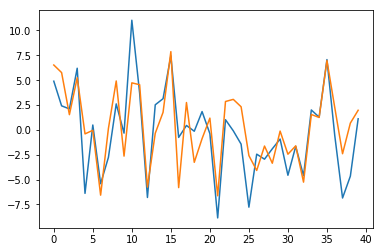

In [21]:
import matplotlib.pyplot as plt
ind = 3
indeces=numpy.arange(len(tru[-6:-1,:,ind].ravel()))
if ind == 3 or ind ==7 or ind ==11:
    plt.plot(indeces,tru[-6:-1,:,ind].ravel(),indeces,(pred[-6:-1,:,ind]*50).ravel())
else:
    plt.plot(indeces,tru[-6:-1,:,ind].ravel(),indeces,pred[-6:-1,:,ind].ravel())
plt.show()

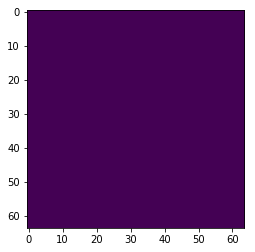

In [32]:
plt.imshow(bAffScan[0,0,42,:,:])

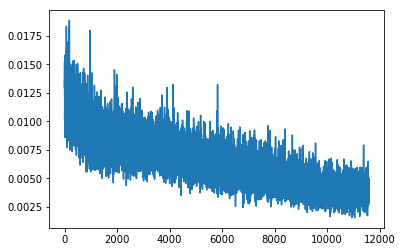

In [30]:
plt.plot(errorPlot[150:])
plt.show()

In [8]:
model.load_weights('model_weights'+saveNames+'.h5')

In [14]:
model.load_weights('model_weights'+saveNames+'-85epochs.h5')

In [9]:
#validation test dataset:
transforms = numpy.genfromtxt('rand_affine_transforms_small_5std_0mu_01std_0mu.csv', delimiter=',')
i=0
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
vSize=150 #4 pairs of images
inBatch=0
testThestas=transforms[-(vSize):]
nameString='saved_small_brains/MCIC-small-test-std5-mu0-64-vsize150'
while inBatch<vSize and i < vSize:
    fname1 = str(testDirectories[i])+'/mri/norm.mgz'
    if os.path.isfile(fname1):
        scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
        if numpy.count_nonzero(scan)!=0: # make sure skull strip is not blank
            #have i already transformed this before?
            inBatch+=1
            if os.path.isfile(nameString+str(inBatch)+'.npy'):
                aScan=numpy.load(nameString+str(inBatch)+'.npy')
            else:
                warp=[transforms[i,0:3],transforms[i,4:7],testThestas[i,8:11]]
                aScan=affine_transform(scan,warp, offset=testThestas[i,3:15:4])
                aScan=numpy.expand_dims(numpy.expand_dims(aScan, axis=0), axis=0)
                #we're gonna save the warp numpy 3d array to save some time later
                numpy.save(nameString+str(inBatch),aScan)
            if inBatch==1:
                v2=aScan
            else:
                v2=numpy.append(v2,aScan,axis=0)
            scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
            if inBatch==1:
                v1=scan
            else:
                v1=numpy.append(v1,scan, axis=0)
    i+=1
testThestas=testThestas[:len(v1)]

In [10]:
import scipy.stats
cortest=model.predict([v1,v2])
cortest*=[1,1,1,50,1,1,1,50,1,1,1,50]
# cortest-testThestas

InternalError: Dst tensor is not initialized.
	 [[Node: _arg_input_2_0_2/_243 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_1895__arg_input_2_0_2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: global_average_pooling3d_1/Mean/_247 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1896_global_average_pooling3d_1/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

In [14]:
print(cortest[1,:],"\n",testThestas[1,:])

[ 1.1265231e+00 -2.0652167e-03 -1.5459895e-02 -1.0301986e-01
 -1.7624807e-02  1.0605487e+00 -6.9709025e-02 -3.5430715e+00
  5.2708548e-02  2.6109338e-02  8.5078901e-01  2.8473225e+00] 
 [ 1.02870899e+00 -5.11137362e-03  1.90314698e-01 -2.04913275e+00
 -5.57702256e-02  1.20155351e+00  9.42866684e-02 -4.09976513e+00
  1.02357079e-01  4.75324692e-03  8.13130212e-01  4.96405423e+00]


In [11]:
for ind in range(12):
    print(ind,scipy.stats.pearsonr(cortest[:,ind],testThestas[:,ind]))

0 (0.030249028189905564, 0.72082636541034)
1 (0.02944002240940178, 0.7279956526701086)
2 (-0.03517320235591197, 0.677731200927469)
3 (0.6574019445628301, 6.32747485395739e-19)
4 (-0.0936799432950382, 0.2674737168059953)
5 (0.03652844316250231, 0.666044247506826)
6 (-0.07424326297850986, 0.37988750632205126)
7 (0.686497834774018, 4.11090747611439e-21)
8 (0.5916508508327921, 8.955517352924744e-15)
9 (0.585912969164489, 1.864522652426792e-14)
10 (0.6144915001981714, 4.164475860467061e-16)
11 (0.6241925262693697, 1.0478969243474071e-16)


In [9]:
#validation test dataset - this time compare different brains with each other and look for MSE:
# transforms = numpy.genfromtxt('rand_affine_transforms_small_5std_5mu.csv', delimiter=',')
i=0
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
vSize=150 #4 pairs of images
inBatch=0
evenOdd = True
# testThestas=transforms[-(vSize):,3:15:4]
# nameString='saved_small_brains_mean5/MCIC-small-test-std5-mu5-64-'
while inBatch<vSize:
    fname1 = str(testDirectories[i])+'/mri/norm.mgz'
    if os.path.isfile(fname1):
        scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
        if numpy.count_nonzero(scan)!=0: # make sure skull strip is not blank
            inBatch+=1
            scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
            if evenOdd:
                if inBatch==1:
                    test2=scan
                else:
                    test2=numpy.append(test2,scan,axis=0)
            else:
                if inBatch==2:
                    test1=scan
                else:
                    test1=numpy.append(test1,scan, axis=0)
    i+=1
    evenOdd = not evenOdd

In [10]:
debug_orig=model.predict([test1,test2])
debug_orig[:,3:15:4]*=50

In [11]:
#test3 is the validation
offset = [debug_orig[0,3],debug_orig[0,7],debug_orig[0,11]]
test3=numpy.squeeze(affine_transform(test1[0,0],[debug_orig[0,0:3],debug_orig[0,4:7],debug_orig[0,8:11]],offset=offset))[numpy.newaxis]
for i in range(1,len(test1)):
    offset = [debug_orig[i,3],debug_orig[i,7],debug_orig[i,11]]
    test3=numpy.append(test3,numpy.squeeze(affine_transform(test1[i,0],[debug_orig[i,0:3],debug_orig[i,4:7],debug_orig[i,8:11]],offset=offset))[numpy.newaxis],axis=0)


In [20]:
ind=28
print(numpy.sum((test1[ind,0].astype('float')-test2[ind,0].astype('float'))**2))
print(numpy.sum((test2[ind,0].astype('float')-test3[ind].astype('float'))**2))

65268210.0
45240942.0


In [12]:
cumsumOrigGraph=[]
cumsumNewGraph=[]
for ind in range(75):
    cumsumOrigGraph.append(numpy.sum((test1[ind,0].astype('float')-test2[ind,0].astype('float'))**2))
    cumsumNewGraph.append(numpy.sum((test2[ind,0].astype('float')-test3[ind].astype('float'))**2))
cumsumOrig=sum(cumsumOrigGraph)
cumsumNew=sum(cumsumNewGraph)

In [13]:
print((cumsumNew-cumsumOrig)/cumsumOrig)

-0.162135868499


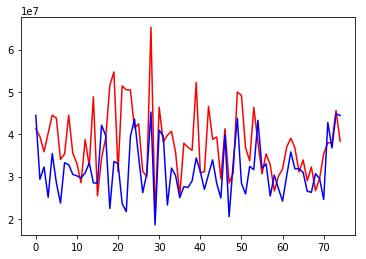

In [15]:
plt.plot(numpy.arange(len(cumsumOrigGraph)),cumsumOrigGraph,'r',cumsumNewGraph,'b')

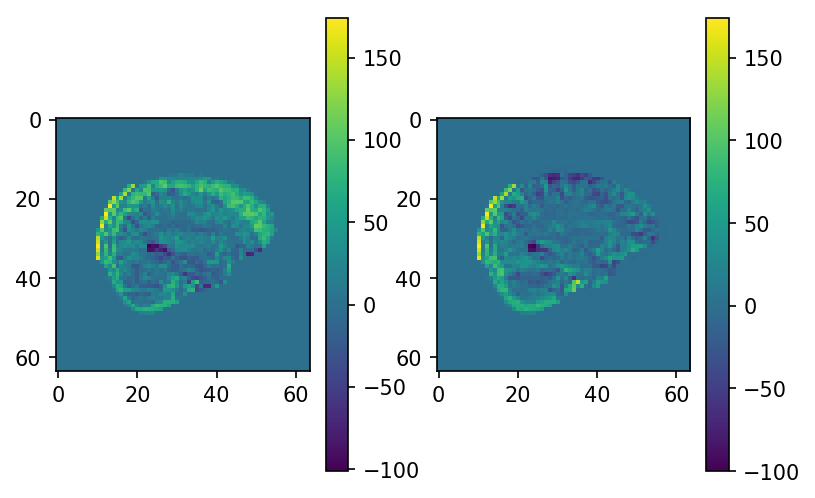

In [27]:
ind=28
zCoord = 40
plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(test2[ind,0,zCoord].astype('float')-test1[ind,0,zCoord].astype('float'))
plt.colorbar()
plt.subplot(122)
plt.imshow(test2[ind,0,zCoord].astype('float')-test3[ind,zCoord].astype('float'))
plt.colorbar()

(64, 64, 64)

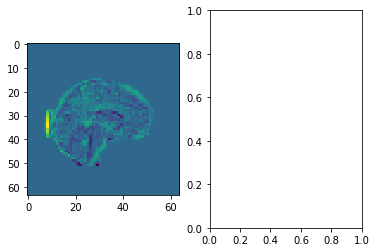

In [47]:
ind=2
plt.subplot(121)
plt.imshow(numpy.squeeze(v1[ind,0].astype('float')-v2[ind,0].astype('float'))[32,...])
plt.subplot(122)
# plt.imshow(numpy.squeeze(v2[ind,0].astype('float')-v3[ind,0].astype('float'))[32,...])
# plt.imshow(numpy.squeeze(v3[ind,0])[32,...])

In [232]:
print(debug_orig-testThestas)

[[ 10.487064    11.58928654  -3.4528689 ]
 [  3.86709007   0.23791238   1.52768277]
 [  2.95049416   2.92509267  -0.96214478]
 [  4.57119502   3.27345235  -1.29640114]]


In [29]:
for i in range(100):
    print(i,model.get_layer(index=i))

0 <keras.engine.topology.InputLayer object at 0x7f6f9d159dd8>
1 <keras.engine.topology.InputLayer object at 0x7f6f9d159d30>
2 <keras.layers.convolutional.Conv3D object at 0x7f6f9d159da0>
3 <keras.layers.normalization.BatchNormalization object at 0x7f6f9d131278>
4 <keras.layers.normalization.BatchNormalization object at 0x7f6f9cf286a0>
5 <keras.layers.core.Activation object at 0x7f6f9d1312b0>
6 <keras.layers.core.Activation object at 0x7f6f9cfa95c0>
7 <keras.layers.convolutional.Conv3D object at 0x7f6f9d159ef0>
8 <keras.layers.normalization.BatchNormalization object at 0x7f6f9d0dfb00>
9 <keras.layers.normalization.BatchNormalization object at 0x7f6f9cf15dd8>
10 <keras.layers.core.Activation object at 0x7f6f9d131710>
11 <keras.layers.core.Activation object at 0x7f6f9cf5ea20>
12 <keras.layers.convolutional.Conv3D object at 0x7f6f9d159f98>
13 <keras.layers.normalization.BatchNormalization object at 0x7f6f9d08cfd0>
14 <keras.layers.normalization.BatchNormalization object at 0x7f6f9ce93518>


ValueError: Was asked to retrieve layer at index 60 but model only has 60 layers.

In [47]:
new_model = keras.models.Model(inputs=model.inputs, outputs=model.get_layer(index=39).output) #index 41 is the last output of 32 feature dim

In [55]:
debug_layer=new_model.predict([v1,v2])

In [48]:
valids=new_model.predict([test1,test2])

In [37]:
lastf=numpy.copy(valids)

In [49]:
print(valids.shape)

(75, 32, 4, 4, 4)


In [45]:
print(debug_layer)

[[ 8.3736092e-01  6.4478584e-02 -4.0682524e-01  1.9678615e-02
   4.5526173e-02  1.8449639e+00 -7.4199410e-03 -7.6485299e-02
  -3.1035827e-03 -3.9183598e-02  7.5595862e-01  3.4675684e-02]
 [ 8.6538380e-01  6.5391168e-02 -3.5723880e-01  1.9252770e-02
   6.0840905e-02  1.7249075e+00 -1.2641325e-02 -7.8219451e-02
  -3.0012061e-03 -2.6452746e-02  7.6913345e-01  3.5574805e-02]
 [ 8.5916841e-01  5.0317451e-02 -3.2567918e-01  1.6790688e-02
   3.9845798e-02  1.7203910e+00 -8.3757555e-03 -6.1933286e-02
  -2.1307392e-03 -3.1540871e-02  7.9941618e-01  4.3249421e-02]
 [ 8.7865347e-01  7.0267968e-02 -5.2582639e-01  2.1973843e-02
   5.7438575e-02  2.2355022e+00 -1.2773520e-02 -8.2704239e-02
  -2.0846610e-03 -3.2513272e-02  7.7416456e-01  4.1596130e-02]]


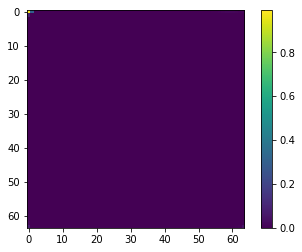

In [67]:
plt.imshow(numpy.squeeze(debug_layer[2,10,32,...]))
plt.colorbar()

In [40]:
mult=lastf.astype('float')*valids.astype('float')

NameError: name 'lastf' is not defined

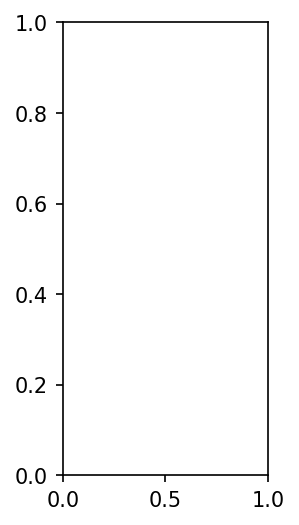

In [22]:
inds=[4,1,30]
plt.figure(dpi=150)
plt.subplot(131)
im1=plt.imshow(numpy.squeeze(lastf[inds[0],inds[1],inds[2],...]))
# plt.imshow(numpy.squeeze(debug_layer[0,33,...]))
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.subplot(132)
im2=plt.imshow(numpy.squeeze(valids[inds[0],inds[1],inds[2],...]))
plt.colorbar(im2,fraction=0.046, pad=0.04)
plt.subplot(133)
im3=plt.imshow(numpy.squeeze(mult[inds[0],inds[1],inds[2],...]))
plt.colorbar(im3,fraction=0.046, pad=0.04)


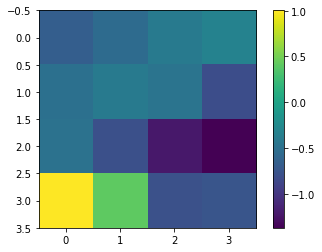

In [52]:
plt.imshow(valids[0,1,0]); plt.colorbar(); plt.show()

(0, 10)

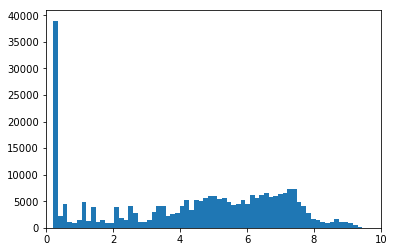

In [34]:
plt.hist(numpy.reshape(debug_layer[3,0,...],-1), bins='auto')
xmin, xmax = plt.xlim()   # return the current xlim
plt.xlim( (0, 10) )  # set the xlim to xmin, xmax

In [25]:
debug2=(numpy.squeeze(debug_layer[0,6,...])*256).astype(int)

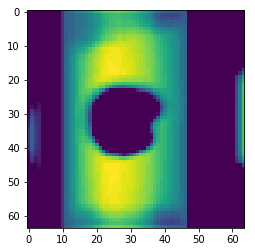

In [29]:
plt.imshow(numpy.squeeze(debug2[15,:,:]))

In [39]:
debug3 = debug2[..., numpy.newaxis] * numpy.ones(3)

In [40]:
debug3.shape

(64, 64, 64, 3)

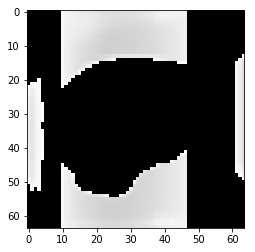

In [44]:
plt.imshow(debug3[40])

In [73]:
gif('featuregif',(numpy.squeeze(debug_layer[0,0,...])*256))


[MoviePy] Building file featuregif.gif with imageio


100%|██████████| 64/64 [00:00<00:00, 197.95it/s]


In [71]:
#store features as gif
from moviepy.editor import ImageSequenceClip


def gif(filename, array, fps=10, scale=1.0):
    """Creates a gif given a stack of images using moviepy
    Notes
    -----
    works with current Github version of moviepy (not the pip version)
    https://github.com/Zulko/moviepy/commit/d4c9c37bc88261d8ed8b5d9b7c317d13b2cdf62e
    Usage
    -----
    >>> X = randn(100, 64, 64)
    >>> gif('test.gif', X)
    Parameters
    ----------
    filename : string
        The filename of the gif to write to
    array : array_like
        A numpy array that contains a sequence of images
    fps : int
        frames per second (default: 10)
    scale : float
        how much to rescale each image by (default: 1.0)
    """

    # ensure that the file has the .gif extension
    fname, _ = os.path.splitext(filename)
    filename = fname + '.gif'

    # copy into the color dimension if the images are black and white
    if array.ndim == 3:
        array = array[..., numpy.newaxis] * numpy.ones(3)

    # make the moviepy clip
    clip = ImageSequenceClip(list(array), fps=fps)
    clip.write_gif(filename, fps=fps)
    return clip

In [42]:
transforms = numpy.genfromtxt('rand_affine_transforms_small.csv', delimiter=',')
i=0
p = Path('/nfs01/data/FS_Slim/ABIDE') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
vSize=4 #4 pairs of images
inBatch=0
testThestas=transforms[-(vSize):]
nameString='saved_small_brains/MCIC-small-test'
while inBatch<vSize:
    fname1 = str(testDirectories[i])+'/mri/norm.mgz'
    if os.path.isfile(fname1):
        scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
        if len(numpy.where(scan!=0))!=1: # make sure skull strip is not blank
            inBatch+=1
            #have i already transformed this before?
            if os.path.isfile(nameString+str(inBatch)+'.npy'):
                aScan=numpy.load(nameString+str(inBatch)+'.npy')
            else:
                aScan=affine_transform(scan,[testThestas[0][0:3],testThestas[0][4:7],testThestas[0][8:11]], offset=[testThestas[0][3],testThestas[0][7],testThestas[0][11]])
                aScan=numpy.expand_dims(numpy.expand_dims(aScan, axis=0), axis=0)
                #we're gonna save the warp numpy 3d array to save some time later
                numpy.save(nameString+str(inBatch),aScan)
            if inBatch==1:
                v2=aScan
            else:
                v2=numpy.append(v2,aScan,axis=0)
            
            scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
            
            if inBatch==1:
                v1=scan
            else:
                v1=numpy.append(v1,scan, axis=0)
    i+=1

In [44]:
##in this block, see if we can overfit a very small portion of the dataset

#read in the transforms; this should only be 7 mB
transforms = numpy.genfromtxt('rand_affine_transforms_small.csv', delimiter=',') 
#throw these pieces in a script.py to do real training
# epoch here will be defined as the abide dataset

errorPlot=[]
testErrors=[]
batchSize=4
tIndex=0
# crop=[25:-25,25:-25,25:-25]
#validation test dataset:
p = Path('/nfs01/data/FS_Slim/MCIC') #brains
testDirectories = [x for x in p.iterdir() if x.is_dir()]
for epoch in tqdm(range(100)):
    for dSet in range(1):
        i=0
        totalError=0
        batchNum=0
        numInBatch=0
        if dSet==0: ##brains must be pulled out of saved_brains in this order otherwise the thetas will not be aligned
            p = Path('/nfs01/data/FS_Slim/ABIDE') #brains
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/ABIDE'
        if dSet==1:
            p = Path('/nfs01/data/FS_Slim/ADHD200') 
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/ADHD200-'
        if dSet==2:
            p = Path('/nfs01/data/FS_Slim/PPMI') 
            subdirectories = [x for x in p.iterdir() if x.is_dir()]
            nameString='saved_small_brains/PPMI'
        while i < 4:
            fname1 = str(subdirectories[i])+'/mri/norm.mgz'
            if os.path.isfile(fname1):
                scan = numpy.array(nib.load(fname1).get_data())[::4,::4,::4]
                if len(numpy.where(scan!=0))!=1: # make sure skull strip is not blank
                    numInBatch+=1
                    tIndex+=1
                    warp=[transforms[tIndex,0:3],transforms[tIndex,4:7],transforms[tIndex,8:11]]
                    offset = [transforms[tIndex,3],transforms[tIndex,7],transforms[tIndex,11]]
                    if os.path.isfile(nameString+str(i)+'.npy'):
                        affScan=numpy.load(nameString+str(i)+'.npy')
                    else:
                        affScan=affine_transform(scan,warp,offset=offset)
                        affScan=numpy.expand_dims(numpy.expand_dims(affScan, axis=0), axis=0)
                        #we're gonna save the warp numpy 3d array to save some time later
                        numpy.save(nameString+str(i),affScan)
                    ##now scale the offset down by 50 (how does this work in tensorflow??)
                    scan=numpy.expand_dims(numpy.expand_dims(scan, axis=0), axis=0)
                    transforms[tIndex]*=[1,1,1,1/80,1,1,1,1/80,1,1,1,1/80]
                    if numInBatch==1:
                        bScan=scan
                        bAffScan=affScan
                        bTransforms=transforms[tIndex][numpy.newaxis]
                    else:
                        bScan=numpy.append(bScan,scan, axis=0)
                        bAffScan=numpy.append(bAffScan,affScan, axis=0)
                        bTransforms=numpy.append(bTransforms, transforms[tIndex][numpy.newaxis], axis=0)
                    if numInBatch==batchSize:    
                        batchNum+=1
                        error=model.train_on_batch([bScan,bAffScan],bTransforms)
                        totalError+=error
                        errorPlot.append(error)
                        # now do some validation error: a different dataset...
                        tErrors=model.test_on_batch([v1,v2],testThestas)
                        testErrors.append(tErrors)
                        print(('at batch num='+str(batchNum)+' error is: '+str(error)+', and validation error is '+str(tErrors)))
                        if batchNum%10==0:
                            printThetas=model.predict([v1,v2])
                            print(printThetas)
                            print('dif is ' + str(numpy.sum(numpy.absolute(printThetas-testThestas))))
                        sys.stdout.flush()
                        numInBatch=0
            i+=1
    print("At epoch"+str(epoch)+", scalar error is: "+str(totalError))
# serialize model to JSON
model_json = model.to_json()
with open("small_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("small_model_weights.h5")
print("Saved model to disk")


  0%|          | 0/100 [00:00<?, ?it/s]

at batch num=1 error is: 0.177443, and validation error is 0.434244



  1%|          | 1/100 [00:01<01:59,  1.21s/it]

At epoch0, scalar error is: 0.177443474531


at batch num=1 error is: 0.189031, and validation error is 0.434444


  2%|▏         | 2/100 [00:02<01:58,  1.20s/it]

At epoch1, scalar error is: 0.189031079412
at batch num=1 error is: 0.152409, and validation error is 0.435017


  3%|▎         | 3/100 [00:03<01:55,  1.20s/it]

At epoch2, scalar error is: 0.152408599854
at batch num=1 error is: 0.148391, and validation error is 0.435777


  4%|▍         | 4/100 [00:04<01:54,  1.19s/it]

At epoch3, scalar error is: 0.14839053154
at batch num=1 error is: 0.182733, and validation error is 0.436806


  5%|▌         | 5/100 [00:05<01:52,  1.18s/it]

At epoch4, scalar error is: 0.18273319304
at batch num=1 error is: 0.157664, and validation error is 0.435043


  6%|▌         | 6/100 [00:07<01:51,  1.19s/it]

At epoch5, scalar error is: 0.157663792372
at batch num=1 error is: 0.149979, and validation error is 0.431275


  7%|▋         | 7/100 [00:08<01:50,  1.19s/it]

At epoch6, scalar error is: 0.149979144335
at batch num=1 error is: 0.147695, and validation error is 0.427625


  8%|▊         | 8/100 [00:09<01:48,  1.18s/it]

At epoch7, scalar error is: 0.147694557905
at batch num=1 error is: 0.129396, and validation error is 0.423613


  9%|▉         | 9/100 [00:10<01:47,  1.18s/it]

At epoch8, scalar error is: 0.129396021366
at batch num=1 error is: 0.138022, and validation error is 0.41868


 10%|█         | 10/100 [00:11<01:42,  1.14s/it]

At epoch9, scalar error is: 0.138022273779
at batch num=1 error is: 0.16157, and validation error is 0.414879


 11%|█         | 11/100 [00:12<01:42,  1.15s/it]

At epoch10, scalar error is: 0.161569952965
at batch num=1 error is: 0.213141, and validation error is 0.412038


 12%|█▏        | 12/100 [00:14<01:41,  1.16s/it]

At epoch11, scalar error is: 0.213140651584
at batch num=1 error is: 0.172833, and validation error is 0.413301


 13%|█▎        | 13/100 [00:15<01:36,  1.11s/it]

At epoch12, scalar error is: 0.172833055258
at batch num=1 error is: 0.189138, and validation error is 0.416576


 14%|█▍        | 14/100 [00:16<01:38,  1.15s/it]

At epoch13, scalar error is: 0.189138367772
at batch num=1 error is: 0.155978, and validation error is 0.420715


 15%|█▌        | 15/100 [00:17<01:38,  1.16s/it]

At epoch14, scalar error is: 0.15597845614
at batch num=1 error is: 0.173565, and validation error is 0.42682


 16%|█▌        | 16/100 [00:18<01:37,  1.17s/it]

At epoch15, scalar error is: 0.173564746976
at batch num=1 error is: 0.168839, and validation error is 0.430953


 17%|█▋        | 17/100 [00:19<01:36,  1.16s/it]

At epoch16, scalar error is: 0.168839290738
at batch num=1 error is: 0.16294, and validation error is 0.437174


 18%|█▊        | 18/100 [00:20<01:36,  1.17s/it]

At epoch17, scalar error is: 0.162940055132
at batch num=1 error is: 0.166214, and validation error is 0.441397


 19%|█▉        | 19/100 [00:22<01:34,  1.17s/it]

At epoch18, scalar error is: 0.166213572025
at batch num=1 error is: 0.130977, and validation error is 0.445208


 20%|██        | 20/100 [00:23<01:35,  1.19s/it]

At epoch19, scalar error is: 0.130977377295
at batch num=1 error is: 0.14958, and validation error is 0.444965


 21%|██        | 21/100 [00:24<01:33,  1.19s/it]

At epoch20, scalar error is: 0.149579823017
at batch num=1 error is: 0.148505, and validation error is 0.442406


 22%|██▏       | 22/100 [00:25<01:32,  1.19s/it]

At epoch21, scalar error is: 0.148505151272
at batch num=1 error is: 0.155398, and validation error is 0.437999


 23%|██▎       | 23/100 [00:26<01:31,  1.19s/it]

At epoch22, scalar error is: 0.155398339033
at batch num=1 error is: 0.121829, and validation error is 0.431817


 24%|██▍       | 24/100 [00:28<01:30,  1.19s/it]

At epoch23, scalar error is: 0.121828638017
at batch num=1 error is: 0.164555, and validation error is 0.423327


 25%|██▌       | 25/100 [00:29<01:30,  1.21s/it]

At epoch24, scalar error is: 0.164555296302
at batch num=1 error is: 0.164522, and validation error is 0.416337


 26%|██▌       | 26/100 [00:30<01:30,  1.22s/it]

At epoch25, scalar error is: 0.164521709085
at batch num=1 error is: 0.16559, and validation error is 0.411885


 27%|██▋       | 27/100 [00:31<01:28,  1.21s/it]

At epoch26, scalar error is: 0.165589779615
at batch num=1 error is: 0.154133, and validation error is 0.407571


 28%|██▊       | 28/100 [00:33<01:26,  1.20s/it]

At epoch27, scalar error is: 0.154133334756
at batch num=1 error is: 0.162277, and validation error is 0.405832


 29%|██▉       | 29/100 [00:34<01:24,  1.20s/it]

At epoch28, scalar error is: 0.162276595831
at batch num=1 error is: 0.15686, and validation error is 0.404622


 30%|███       | 30/100 [00:35<01:24,  1.21s/it]

At epoch29, scalar error is: 0.156859815121
at batch num=1 error is: 0.14614, and validation error is 0.404695


 31%|███       | 31/100 [00:36<01:22,  1.20s/it]

At epoch30, scalar error is: 0.146140038967
at batch num=1 error is: 0.148122, and validation error is 0.408804


 32%|███▏      | 32/100 [00:37<01:20,  1.19s/it]

At epoch31, scalar error is: 0.14812207222
at batch num=1 error is: 0.115653, and validation error is 0.412895


 33%|███▎      | 33/100 [00:38<01:19,  1.18s/it]

At epoch32, scalar error is: 0.115653127432
at batch num=1 error is: 0.146746, and validation error is 0.418708


 34%|███▍      | 34/100 [00:40<01:19,  1.20s/it]

At epoch33, scalar error is: 0.146745637059
at batch num=1 error is: 0.127245, and validation error is 0.424651


 35%|███▌      | 35/100 [00:41<01:18,  1.21s/it]

At epoch34, scalar error is: 0.127244770527
at batch num=1 error is: 0.160921, and validation error is 0.427872


 36%|███▌      | 36/100 [00:42<01:18,  1.22s/it]

At epoch35, scalar error is: 0.160920932889
at batch num=1 error is: 0.151821, and validation error is 0.42601


 37%|███▋      | 37/100 [00:43<01:17,  1.23s/it]

At epoch36, scalar error is: 0.151820838451
at batch num=1 error is: 0.139626, and validation error is 0.42236


 38%|███▊      | 38/100 [00:45<01:15,  1.22s/it]

At epoch37, scalar error is: 0.13962584734
at batch num=1 error is: 0.163856, and validation error is 0.418486


 39%|███▉      | 39/100 [00:46<01:13,  1.20s/it]

At epoch38, scalar error is: 0.163856223226
at batch num=1 error is: 0.141856, and validation error is 0.417269


 40%|████      | 40/100 [00:47<01:11,  1.20s/it]

At epoch39, scalar error is: 0.141855761409
at batch num=1 error is: 0.147487, and validation error is 0.413356


 41%|████      | 41/100 [00:48<01:10,  1.20s/it]

At epoch40, scalar error is: 0.147487446666
at batch num=1 error is: 0.177192, and validation error is 0.410834


 42%|████▏     | 42/100 [00:49<01:08,  1.18s/it]

At epoch41, scalar error is: 0.177192479372
at batch num=1 error is: 0.178654, and validation error is 0.411909


 43%|████▎     | 43/100 [00:51<01:08,  1.21s/it]

At epoch42, scalar error is: 0.178653985262
at batch num=1 error is: 0.154726, and validation error is 0.415616


 44%|████▍     | 44/100 [00:52<01:07,  1.20s/it]

At epoch43, scalar error is: 0.154726237059
at batch num=1 error is: 0.136165, and validation error is 0.420638


 45%|████▌     | 45/100 [00:53<01:06,  1.21s/it]

At epoch44, scalar error is: 0.13616541028
at batch num=1 error is: 0.145213, and validation error is 0.426196


 46%|████▌     | 46/100 [00:54<01:04,  1.20s/it]

At epoch45, scalar error is: 0.14521305263
at batch num=1 error is: 0.137312, and validation error is 0.430353


 47%|████▋     | 47/100 [00:55<01:03,  1.19s/it]

At epoch46, scalar error is: 0.137311547995
at batch num=1 error is: 0.130726, and validation error is 0.434014


 48%|████▊     | 48/100 [00:57<01:01,  1.19s/it]

At epoch47, scalar error is: 0.130725562572
at batch num=1 error is: 0.14258, and validation error is 0.436498


 49%|████▉     | 49/100 [00:58<01:00,  1.19s/it]

At epoch48, scalar error is: 0.142579913139


KeyboardInterrupt: 

In [19]:
# prediction: NOTE THE TRANSLATIONS HAVE TO BE SCALED UP 80X
p = Path('/nfs01/data/FS_Slim/ADHD200') #brains
subdirectories = [x for x in p.iterdir() if x.is_dir()]
fname1 = str(subdirectories[8])+'/mri/norm.mgz'
scan1 = numpy.array(nib.load(fname1).get_data())
scan1Copy=numpy.copy(scan1)
scan1=numpy.expand_dims(numpy.expand_dims(scan1, axis=0), axis=0)
fname2 = str(subdirectories[9])+'/mri/norm.mgz'
scan2 = numpy.array(nib.load(fname2).get_data())
scan2Copy=numpy.copy(scan2)
scan2=numpy.expand_dims(numpy.expand_dims(scan2, axis=0), axis=0)
thetaPredict=model.predict([scan1,scan2])
thetaPredict*=[1,1,1,80,1,1,1,80,1,1,1,80]
affScan1=affine_transform(scan1Copy, [thetaPredict[0][0:3],thetaPredict[0][4:7],thetaPredict[0][8:11]], offset=[thetaPredict[0][3],thetaPredict[0][7],thetaPredict[0][11]])

In [90]:
affScan2=affine_transform(scan2Copy, [thetaPredict[0][0:3],thetaPredict[0][4:7],thetaPredict[0][8:11]], offset=[thetaPredict[0][3],thetaPredict[0][7],thetaPredict[0][11]])

In [11]:
# need to convert the float subtractions so that they fit in the range so they can be drawn
def shortenRange(arr):
    oldRange=numpy.amax(arr)-numpy.amin(arr)
    newRange=255
    return (((arr-numpy.amin(arr))*newRange)/oldRange)

In [13]:
# from imageio we get the tools to make a gif out of these brains
from imageio import imageio
def makeVid(gifName, arr):
    images=[]
    for i in range(151):
        images.append(arr[i])
    imageio.mimsave(gifName, images)

In [61]:
# stackScan1Copy=numpy.stack((scan1Copy,)*3)
makeVid('source_brain_short.mp4',scan1Copy[50:201])
makeVid('target_brain_short.mp4',scan2Copy[50:201])

In [21]:
print(thetaPredict)

[[  9.83956516e-01   4.49096747e-02   9.93389264e-03   6.31023121e+00
    2.29902565e-02   9.86945152e-01   3.86407692e-03  -9.34448242e-01
   -1.90142281e-02   4.37331572e-02   9.50456798e-01  -1.12441123e-01]]


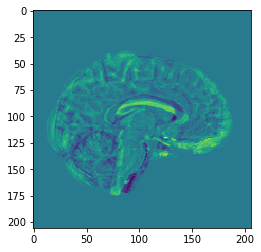

In [15]:
oldDif=scan2Copy.astype(numpy.float32)-scan1Copy.astype(numpy.float32)
oldDif=shortenRange(oldDif).astype(numpy.uint8)
plt.imshow(oldDif[100])
makeVid('old_difference.mp4',oldDif[50:201])
newDif=scan2Copy.astype(numpy.float32)-affScan1.astype(numpy.float32)
newDif=shortenRange(newDif).astype(numpy.uint8)
makeVid('new_difference.mp4',newDif[50:201])

NameError: name 'affScan2' is not defined

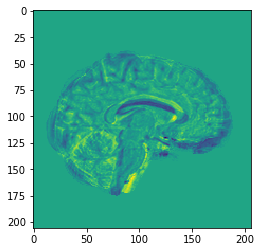

In [14]:
oldDif=scan1Copy.astype(numpy.float32)-scan2Copy.astype(numpy.float32)
oldDif=shortenRange(oldDif).astype(numpy.uint8)
plt.imshow(oldDif[100])
makeVid('old_difference.mp4',oldDif[50:201])
newDif=scan1Copy.astype(numpy.float32)-affScan2.astype(numpy.float32)
newDif=shortenRange(newDif).astype(numpy.uint8)
makeVid('new_difference.mp4',newDif[50:201])

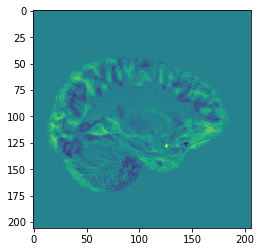

In [22]:
# plt.imshow(oldDif[100])
plt.imshow(oldDif[125])

In [20]:
print(numpy.sum((scan2Copy.astype(numpy.float32)-scan1Copy.astype(numpy.float32))**2), numpy.sum((scan2Copy.astype(numpy.float32)-affScan1.astype(numpy.float32))**2))

1.98506e+09 3.46213e+09


In [98]:
print(numpy.sum((scan1Copy.astype(numpy.float32)-affScan2.astype(numpy.float32))**2))

2.24908e+09
